In [1]:
from jax import lax, random, numpy as jnp
from train.trainer import create_train_state, Trainer
from model import GPT
import jax
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle
%matplotlib inline

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
config = {
    "n_layers": 1,
    "n_head": 7,
    "n_embd": 21,
    "vocab_size": 3,
    "block_size": 11,
    "embd_pdrop": 0.1
}
learning_rate = 0.01
momentum = 0.99

In [3]:
model = GPT(**config)

In [4]:
key1, key2, dropout_key = random.split(random.PRNGKey(1), 3)

init_rng = {"params": key2, 'dropout' : dropout_key}

In [5]:
state = create_train_state(model, init_rng, learning_rate, momentum, config, key=dropout_key)

In [6]:
class SortDataset(Dataset):
    """
    Dataset for the Sort problem. E.g. for problem length 6:
    Input: 0 0 2 1 0 1 -> Output: 0 0 0 1 1 2
    Which will feed into the transformer concatenated as:
    input:  0 0 2 1 0 1 0 0 0 1 1
    output: I I I I I 0 0 0 1 1 2
    where I is "ignore", as the transformer is reading the input sequence
    """

    def __init__(self, split, length=(config["block_size"]+1)//2, num_digits=config["vocab_size"]):
        assert split in {'train', 'test'}
        self.split = split
        self.length = length
        self.num_digits = num_digits

    def __len__(self):
        return 10000 # ...

    def get_vocab_size(self):
        return self.num_digits

    def get_block_size(self):
        # the length of the sequence that will feed into transformer,
        # containing concatenated input and the output, but -1 because
        # the transformer starts making predictions at the last input element
        return self.length * 2 - 1

    def __getitem__(self, idx):

        # use rejection sampling to generate an input example from the desired split
        while True:
            # generate some random integers
            inp = torch.randint(self.num_digits, size=(self.length,), dtype=torch.long)
            # half of the time let's try to boost the number of examples that
            # have a large number of repeats, as this is what the model seems to struggle
            # with later in training, and they are kind of rate
            if torch.rand(1).item() < 0.5:
                if inp.unique().nelement() > self.length // 2:
                    # too many unqiue digits, re-sample
                    continue
            # figure out if this generated example is train or test based on its hash
            h = hash(pickle.dumps(inp.tolist()))
            inp_split = 'test' if h % 4 == 0 else 'train' # designate 25% of examples as test
            if inp_split == self.split:
                break # ok

        # solve the task: i.e. sort
        sol = torch.sort(inp)[0]

        # concatenate the problem specification and the solution
        cat = torch.cat((inp, sol), dim=0)

        # the inputs to the transformer will be the offset sequence
        x = cat[:-1].clone()
        y = cat[1:].clone()
        # we only want to predict at output locations, mask out the loss at the input locations
        y[:self.length-1] = -1
        return x, y

In [7]:
trainer = Trainer(SortDataset("train"), SortDataset("test"), train_state=state)

In [8]:
trainer.run_trainer(3)

100%|██████████| 157/157 [00:04<00:00, 34.56it/s]


{'train_loss': [Array(0.15846236, dtype=float32),
  Array(0.00169939, dtype=float32),
  Array(0.00014436, dtype=float32)],
 'train_accuracy': [Array(0.934234, dtype=float32),
  Array(0.99981916, dtype=float32),
  Array(1., dtype=float32)],
 'test_loss': [Array(0.01187542, dtype=float32),
  Array(0.00050877, dtype=float32),
  Array(2.727856e-05, dtype=float32)],
 'test_accuracy': [Array(0.9965805, dtype=float32),
  Array(1., dtype=float32),
  Array(1., dtype=float32)]}

In [9]:
print(trainer.metrics_history)

{'train_loss': [Array(0.15846236, dtype=float32), Array(0.00169939, dtype=float32), Array(0.00014436, dtype=float32)], 'train_accuracy': [Array(0.934234, dtype=float32), Array(0.99981916, dtype=float32), Array(1., dtype=float32)], 'test_loss': [Array(0.01187542, dtype=float32), Array(0.00050877, dtype=float32), Array(2.727856e-05, dtype=float32)], 'test_accuracy': [Array(0.9965805, dtype=float32), Array(1., dtype=float32), Array(1., dtype=float32)]}


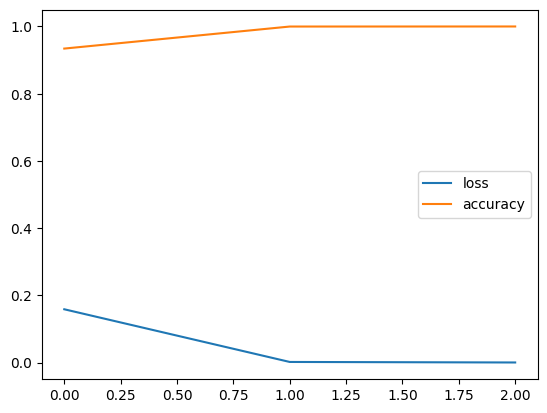

In [17]:
train_loss = trainer.metrics_history["train_loss"]
plt.plot(np.arange(0, len(train_loss), 1), train_loss, label="loss")
train_accuracy = trainer.metrics_history["train_accuracy"]
plt.plot(np.arange(0, len(train_accuracy), 1), train_accuracy, label="accuracy")
plt.legend()

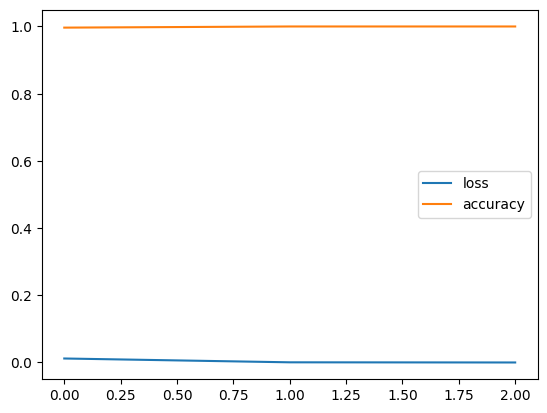

In [18]:
test_loss = trainer.metrics_history["test_loss"]
plt.plot(np.arange(0, len(test_loss), 1), test_loss, label="loss")
test_accuracy = trainer.metrics_history["test_accuracy"]
plt.plot(np.arange(0, len(test_accuracy), 1), test_accuracy, label="accuracy")
plt.legend()

In [20]:
dataloader = DataLoader(SortDataset("test"), batch_size=1)
x, y = next(iter(dataloader))
print(x, y)
x, y = jnp.array(x), jnp.array(y)
batch = (x, y)
pred = trainer.train_state.apply_fn(state.params, x, training=False)
print(pred)
print(jnp.argmax(pred, axis=-1))
print(y)

zeros = jnp.zeros_like(y, dtype=int)

predictions = jnp.argmax(pred, axis=-1)
predictions_masked =  lax.select(y == -1, zeros-1, predictions)
print(predictions_masked)


tensor([[0, 0, 2, 2, 2, 1, 0, 0, 1, 2, 2]]) tensor([[-1, -1, -1, -1, -1,  0,  0,  1,  2,  2,  2]])
[[[ 0.12080386  0.04499314 -0.1680934 ]
  [ 0.05534431  0.01718597 -0.13706285]
  [-0.00967472  0.12158204  0.0807227 ]
  [-0.0505431   0.01018693  0.00364835]
  [-0.01390173  0.04413539  0.03638929]
  [-0.14226137  0.03327711  0.07552318]
  [ 0.05597778  0.04033387  0.04765469]
  [ 0.14061388  0.00896668 -0.04333903]
  [-0.10313082 -0.10670202  0.01861088]
  [ 0.01355137  0.02536171 -0.02603966]
  [-0.01562809 -0.08709169  0.01153092]]]
[[0 0 1 1 1 2 0 0 2 1 2]]
[[-1 -1 -1 -1 -1  0  0  1  2  2  2]]
[[-1 -1 -1 -1 -1  2  0  0  2  1  2]]
